<h1 style='text-align: center;'> Independent Natural Language Processing Project 1</h1> 
<h3 style='text-align: center;'> By Sri Das </h3>

<h2 style='text-align: center;'> Matching Resume To Skills From Job Postings </h2>

### Importing requires packages

In [1]:
import glob
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
import string
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

In [2]:
# Loading job postings from resective html files using glob

job_postings = glob.glob('/Users/priyadas/Downloads/job_postings/*.html')

len(job_postings)

1458

In [3]:
# Reading the contents of the html files using Beautifulsoup and saving them into a
# vairiable called 'files'

files = []

for i in range(len(job_postings)): 
    file = open(job_postings[i], 'r')
    index=file.read()
    S = BeautifulSoup(index, 'html')
    files.append(S)
    
len(files)

1458

To filter the relevant jobs from the job listings, two methods have been used. In the first one, the titles are filteres based on relevant keywords. In the second method, the jobs are filteres using the similarity between the skills listed in the resume with job postings. 

### Filtering job requirements using keywords

In [4]:
# Defining relevant keywords to filter the jobs 
keywords = ['data', 'data scientist', ' data science', 'python', 'machine', 'learning', 'ml', 'natural', 'language', 'processing'
            '/data', '\data', 'data analyst', 'ml/data', 'ai']

In [5]:
# Filtering job postings if any of the keywords are present in the title

data_sci = [] #data science jobs
others = [] #other jobs
titles_ds =[] # data science job titles
irr_titles= [] # irrelevant job titles

for i in files :
    
    job_title = i.title.text.lower().split()
    ct = 0
    
    for w in keywords :
        if w in job_title:
          ct+=1
   
    if ct == 0 :
        others.append(i)
        irr_titles.append(i.title.text)
    else :
        data_sci.append(i)
        titles_ds.append(i.title.text)

In [6]:
print('No. of data science related jobs are {} and other jobs are {}'.format(
        len(data_sci), len(others)))

No. of data science related jobs are 825 and other jobs are 633


Capturing the qualifications : most of the job postings had required skills as a bulleted list. The html tag for the bulleted list is 'li'. From the data science job postings, these skills and respective titles are filtered.

In [7]:
qual = [] #skills or qualifications
titles = [] # respective title
jobs = [] # respective job posting

for S in data_sci:
    results = S.body.find_all('li')
    line = '' 
    for bullet in results :
        line += (bullet.text + ' ')
    jobs.append(S)
    qual.append(line)
                              
    job_title = S.title.text.lower()
    titles.append(job_title)

Once the relevant jobs are filtered. Next this data needs to cleaned. Here I used removing new line, other special characters, numbers, single letter words and stop words before futher processing the data. 

### Cleaning the text data

In [8]:
# Function to clean the text data

def text_clean(text) :
    text = text.lower() 
    text = re.sub(r'([^a-zA-Z\s]+?)', ' ', text) 
    text = re.sub(' +', ' ', text)
    text_clean = ' '.join( [w for w in text.split() if len(w)>1] )
    return text_clean

In [9]:
qual_clean = []
for i in qual :
    qual_clean.append(text_clean(i))

Setting up relevant stopwords

In [10]:
stpwords = stopwords.words('english')
len(stpwords)

179

In [11]:
# Additional relevant stopwords - based on common words used in job descriptions but are not skills
stpwords.extend(['experience', 'years', 'environment', 'knowledge','ability', 'skills', 'performance', 
                  'work', 'field', 'methods', 'relevant', 'understanding', 'advanced', 
                  'multiple', 'team', 'related', 'problems','etc'])

In [12]:
#Function to remove stopwords from the text, returns text without stopwords and number of words removed

def rem_stpwrds(text): 
    count = 0
    #text_clean = []
    words = text.split()
    text_clean = ''
    for w in words:
        if w not in stpwords:
            text_clean = text_clean + w + ' '
        else :
            count += 1
            
    return text_clean, count

### Removing stopwords

In [13]:
no_sw = []
count = 0
for i in qual_clean : 
    text, c = rem_stpwrds(i)
    no_sw.append(text)
    count = count + c
print('Number of stopwords removed = ', count)

Number of stopwords removed =  66622


### TFIDF Vectorizer

In [14]:
tokenizer = RegexpTokenizer(r'\w+')

In [15]:
# Applying tfidf vectorization to generate the vectorized sparse matrix

tfidf_vect_ds = TfidfVectorizer(max_df=0.8, max_features=500,
                                 min_df=0.2, stop_words=stpwords,
                                 use_idf=True, tokenizer=tokenizer.tokenize, ngram_range=(1,3))

tfidf_matrix_ds = tfidf_vect_ds.fit_transform(no_sw) 

print('The tfidf resulted in {} features'.format(tfidf_matrix_ds.shape[1]))

The tfidf resulted in 91 features


In [16]:
# Converting the sparse matrix to a dataframe with weights and respective tfidf features

tfidf_ds = pd.DataFrame(tfidf_matrix_ds[0].T.todense(), index=tfidf_vect_ds.get_feature_names_out(), columns=['TFIDF'])
skills_set = tfidf_ds.sort_values('TFIDF', ascending=False).head(25)

In [17]:
# Printing the words with top 25 tfidf scores
print(skills_set)

                     TFIDF
learning          0.366793
machine learning  0.255641
machine           0.254631
java              0.219465
scikit learn      0.218980
solving           0.218018
scikit            0.217067
plus              0.216126
problem           0.216126
technologies      0.213817
tensorflow        0.212013
spark             0.210246
excellent         0.194679
deep              0.188681
learn             0.186328
analytical        0.185667
software          0.180864
modeling          0.173982
algorithms        0.173982
communication     0.162421
strong            0.145345
statistics        0.140522
python            0.114113
product           0.000000
research          0.000000


From the above results it can be seen that a good number of data science topics/tools made it to the list using tfidf vectorizer method.

### Clustering

We will use K-means clustering to cluster the data and obtain the top keywords of each clusters. Before performing the kmeans, we will use the elbow method to determine the number of clusters

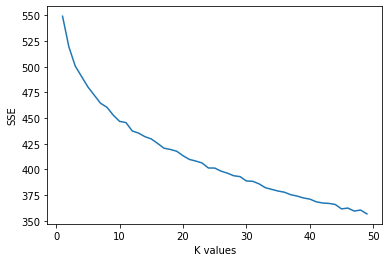

In [18]:
sse={}
for k in np.arange(1,50,1):
    kmeans = KMeans(n_clusters=k,init='k-means++', random_state =42).fit(tfidf_matrix_ds)
    sse[k] = kmeans.inertia_
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('K values')
plt.ylabel('SSE')
plt.show();

In the above curve, there is no pronounced elbow for 'K' value. This usually can mean that there are no strong clusters and/or tha algorithm is not able to separate them. This needs to be corroborated by visualization of the clusters. Cluster are visualized by creating wordcloud of the cluster terms and also by looking at the top 10 keywords of each cluster. First we will run the kmeans clustering with a k value of 10 (from the graph the 'soft' elbow occurs around 10).

In [19]:
# Applying k-means clustering with 10 clusters 

num_clusters = 10

km = KMeans(n_clusters=num_clusters, init='k-means++', random_state =42)

km.fit(tfidf_matrix_ds)

clust_ds = km.labels_.tolist()

In [20]:
# A function to generate word cloud
def word_cloud(text, n, stopword_list):

    word_cloud = WordCloud(width = 800, height = 500, 
                           background_color ='white', 
                           stopwords = stopword_list, 
                           min_font_size = 14).generate(text) 

    plt.figure(figsize = (8, 6)) 
    
    plt.title('Cluster:' + str(n))
    
    plt.imshow(word_cloud) 

    plt.show()

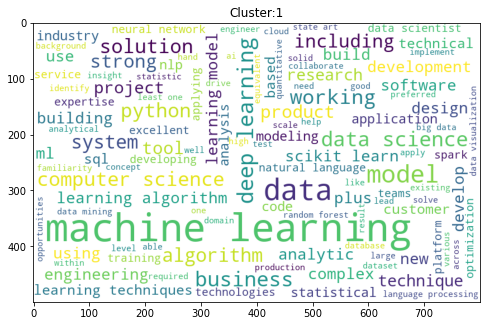

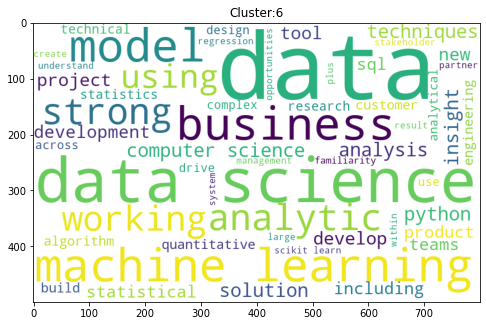

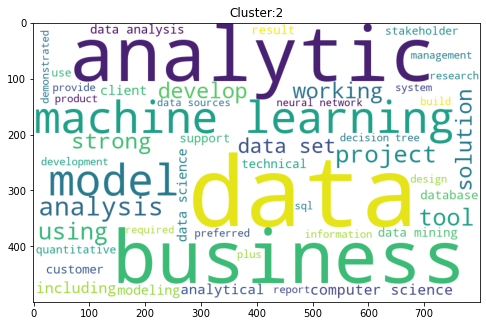

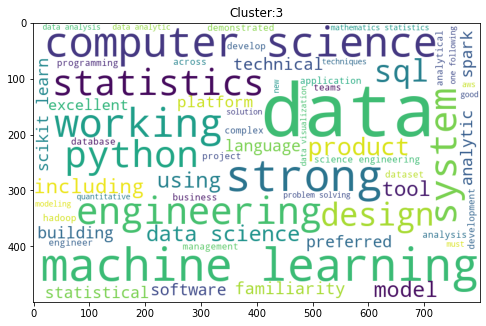

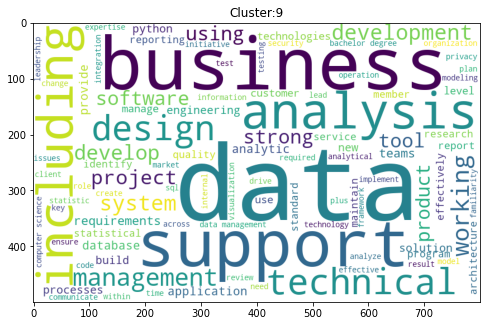

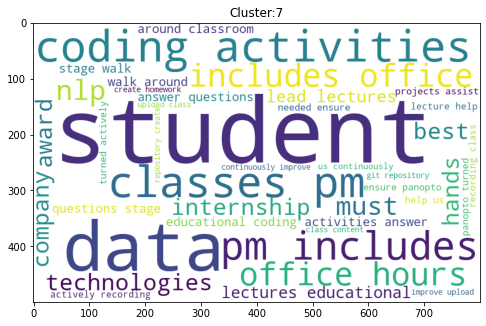

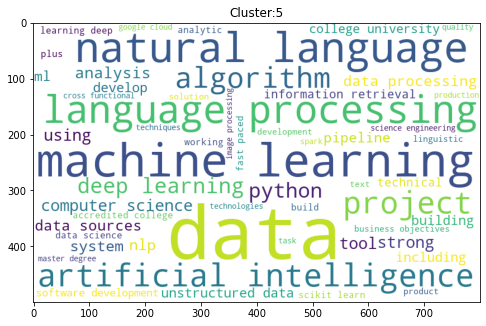

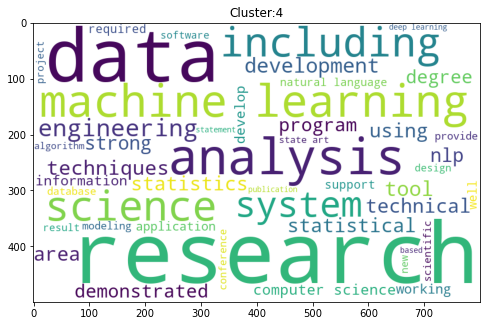

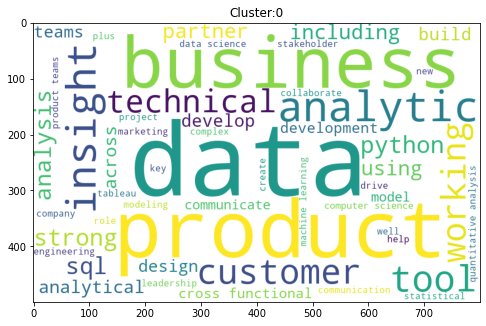

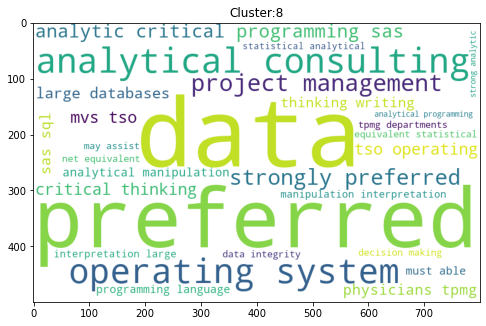

In [21]:
# Generating a dataframe with text data and cluster labels
df_1=pd.DataFrame({"text":no_sw,"labels":km.labels_})

# For each cluster the word cloud is generated by calling the function 'word_cloud'
for i in df_1.labels.unique():
    new_df=df_1[df_1.labels==i]
    text="".join(new_df.text.tolist())
    word_cloud(text, i, stpwords)

Let's look at the top 10 keywords from each cluster

In [22]:
skills_set_ds = []

print("Top keywords per cluster: \n")
cent_order = km.cluster_centers_.argsort()[:, ::-1]
keywords = tfidf_vect_ds.get_feature_names_out()
for i in range(num_clusters):
    
    print("Cluster %d:" % i),
    
    for n in cent_order[i, :10]:
        print('%s' % keywords[n], end=' ')
        skills_set_ds.append(keywords[n])


    print('\n')
    
skills_set_clust = ' '.join(skills_set_ds) # saving the top 10 terms of each cluster

Top keywords per cluster: 

Cluster 0:
product business insights teams analysis quantitative analytics technical engineering tools 

Cluster 1:
learning machine machine learning algorithms deep models science techniques tensorflow python 

Cluster 2:
analysis business statistical analytics models techniques modeling using regression predictive 

Cluster 3:
engineering science strong learning computer computer science working programming systems python 

Cluster 4:
research learning information machine analysis machine learning language science computer one 

Cluster 5:
processing language learning business machine learning machine development using python management 

Cluster 6:
data science science learning business machine models machine learning techniques analysis strong 

Cluster 7:
support time projects bachelor pandas across excellent sql technologies learning 

Cluster 8:
preferred management analytical databases complex systems statistical software information including 

Clus

From both the wordcloud visualization and keywords extraction it can be seen that there is an overlap of terms in clusters. In other words, the algorithm is unable to separate the topics into individual clusters. Another technique 'Latent Dirichlet Allocation' or LDA, that decides topics based on word counts rather than distances (which is used in Kmeans) 

In [23]:
from sklearn.decomposition import LatentDirichletAllocation

lda=LatentDirichletAllocation(n_components=10,learning_method='online',random_state=42,max_iter=1) 
lda_ds=lda.fit_transform(tfidf_matrix_ds)

In [24]:
# Printing the topic probabilities obtained from LDA

print("Document 0: ")
for i,topic in enumerate(lda_ds[0]):
  print("Topic ",i,": ",topic*100,"%")

Document 0: 
Topic  0 :  1.7652234503669157 %
Topic  1 :  1.7654516970856313 %
Topic  2 :  84.11154104066263 %
Topic  3 :  1.7653024282476122 %
Topic  4 :  1.7652951180232868 %
Topic  5 :  1.765492794549714 %
Topic  6 :  1.7652959709371732 %
Topic  7 :  1.7654315793095197 %
Topic  8 :  1.765294883022088 %
Topic  9 :  1.7656710377954323 %


In [25]:
# Print top 10 terms of each topic

features = tfidf_vect_ds.get_feature_names_out()
topic_words = []
topic_words_10 = []

for i, comp in enumerate(lda.components_):
     
     feat_comp = zip(features, comp)
     
     all_terms = sorted(feat_comp, key= lambda x:x[1], reverse=True)
     topic_words.append(all_terms) # all terms of the topic
          
     sorted_terms = all_terms[:10] # top 10 terms of the topic
     topic_words_10.append(all_terms[:10]) 

     print("Topic "+str(i)+": ")
     for t in sorted_terms:
            print(t[0], end=' ')
     print('\n')

Topic 0: 
analysis statistical quality predictive complex engineering excellent solutions information science 

Topic 1: 
research learning machine machine learning time one science projects python support 

Topic 2: 
learning machine machine learning language algorithms strong learn processing science scikit 

Topic 3: 
build working technical projects tools development support analysis language learning 

Topic 4: 
product strong insights software high working research analysis development learning 

Topic 5: 
business analysis analytics statistical learning models science tools analytical technical 

Topic 6: 
learning machine machine learning models business product science use solutions data science 

Topic 7: 
engineering science degree technical strong bachelor computer analysis software statistics 

Topic 8: 
product business including teams support working management research based software 

Topic 9: 
learning machine machine learning science models systems using techniques e

From the results it can be seen that 84% of the documents fall under topic 2. Hence topic 2 are the relevant skills/tools required for a data science job.

In [26]:
# Skills set requirments based on lda
skills_set_lda = topic_words[2]

### Resume match

It is time to compare the skills of the resume to both skills sets obtained from kmeans clustering and LDA. First, the resume text is cleaned to remove, special characters, digits and stop words. Then the resume is compared to both the skills sets based on cosine similarity

In [27]:
resume = ''
with open('resume.txt') as f:
    for line in f.readlines():
        resume += line

In [28]:
resume = text_clean(resume)
resume

'experience developed probability simulations using numpy assessed online ad clicks for statistical significance using permutation testing analyzed disease outbreaks using common clustering algorithms additional skills data visualization using matplotlib statistical analysis using scipy processing structured tables using pandas executing means clustering and dbscan clustering using scikit learn extracting locations from text using geonamescache location analysis and visualization using geonamescache and basemap dimensionality reduction with pca and svd using scikit learn nlp analysis and text topic detection using scikit learn'

Since the Kmeans clustering did not generate specific clusters, the top ten terms of each cluster are selected to compare with the resume for matching skills. 

In [29]:
# Skills set from Kmean clustering (as text)

skills_clust = ' '.join(set(skills_set_clust.split())) # removing duplicates
skills_clust

'data machine excellent databases information technologies processing modeling software insights management preferred design technical techniques analysis statistical projects models regression programming including quantitative science deep python tools time research analytics systems analytical strong one across teams working complex tensorflow pandas product using engineering business predictive algorithms learning computer bachelor development language support sql'

In [30]:
text_clust = [resume, skills_clust]
cv = CountVectorizer()
cnt_mat = cv.fit_transform(text_clust)
print("\nSimilarity Scores:")
print(cosine_similarity(cnt_mat))


Similarity Scores:
[[1.         0.17696343]
 [0.17696343 1.        ]]


In [31]:
match_per = cosine_similarity(cnt_mat)[0][1] * 100
match_per = round(match_per, 2)  
print("Resume matches about "+ str(match_per)+ "% of the skills set generated by KMeans clustering.")

Resume matches about 17.7% of the skills set generated by KMeans clustering.


Repeating the same process from the skills set generated from LDA (Topic 2)

In [32]:
skills_lda = []
for i in range(len(skills_set_lda)):
    skills_lda.append(skills_set_lda[i][0])

In [33]:
skills_lda_2 = ' '.join(skills_lda)

# Skills set from LDA topic 2 
skills_lda_2  

'learning machine machine learning language algorithms strong learn processing science scikit python using deep analysis tensorflow scikit learn techniques research working tools excellent programming spark models data science pandas engineering communication statistics plus one visualization computer development statistical technical large business computer science modeling sets java solutions complex building preferred software including sql new written identify product systems solving analytics information design develop phd degree insights mathematics analytical quality technologies languages across communicate regression time quantitative use build projects predictive teams based problem results management decision master model databases testing bachelor drive provide support high'

In [34]:
text_lda = [resume, skills_lda_2]
cv = CountVectorizer()
cnt_mat = cv.fit_transform(text_lda)
print("\nSimilarity Scores:")
print(cosine_similarity(cnt_mat))


Similarity Scores:
[[1.         0.21399224]
 [0.21399224 1.        ]]


In [35]:
match_per = cosine_similarity(cnt_mat)[0][1] * 100
match_per = round(match_per, 2)  
print("Resume matches about "+ str(match_per)+ "% of the skills set generated by LDA.")

Resume matches about 21.4% of the skills set generated by LDA.


### Conclusion

The job descriptions from the job posting as htmls files are parsed. The parsed data is further filtered using 'Data Science' realted keywords to obtain the relevant job postings. The relevant job posting text was pre processed to remove special characters, digits and stopwords. The goal of the project was to extract the skills required for a data science jobs based on the job descriptions. To achieve this, two techniques were used: KMeans clustering and LDA of the vectorized data (TFIDF). 

For Kmeans clustering, 'Elbow method' was used to determine the number of clusters. This however did not result in a prominent elbow indicatin that the clusters may not be well defined or overlapping. This was indeed confirmed using visualizations through wordclouds and listing the top 10 terms of each cluster. The terms overlapped among clusters and the clusters themselves did not point a defined skill, tool or techniques of data science.  

The second technique LDA, resulted in a topic probability of 84%; indicating that majority of the job listings had words from this topic. All the terms from this topic were selected as the required skill set for a data science job. 

The resume was then compared to both the skills set from Kmeans and LDA using cosine similarity. The resume matched 17.7% of the skills from KMeans clustering and 21.4% of the skills from LDA. The TFIDF and LDA scores of 'machine learning' are very high. So improving/adding some 'machine learning' skills to the resume will increase the match and will also improve chances of getting hired. 

Further, the text data can be cleaned further to reduce the noise/unwanted terms. However, both lemmatization and stemming did not have a great improvement in the TFIDF weights. 